In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import csv
import os
import time

random.seed(42)
np.random.seed(42)

In [4]:
dataset_path = "../data/train_small_regression.csv"

### Preprocessing

In [ ]:
dfs = []

for i in range(5):

    prompt_path = f"../experiment/input/small_{i}.csv"
    result_path = f"../experiment/result/small_{i}-result.csv"
    
    # 读取两个文件
    df_prompt = pd.read_csv(prompt_path)
    df_result = pd.read_csv(result_path)
    
    # 对齐字段名
    df_prompt.rename(columns={"id": "Id"}, inplace=True)
    
    # 合并
    df_merged = pd.merge(df_prompt, df_result, on="Id")
    
    # 选取字段
    df_filtered = df_merged[["Id", "step", "cfg", "width", "height", "token_count", "sampler", "Duration"]]
    
    # 添加进列表
    dfs.append(df_filtered)

# 合并所有数据
df_all = pd.concat(dfs, ignore_index=True)

# 保存
df_all.to_csv(dataset_path, index=False)


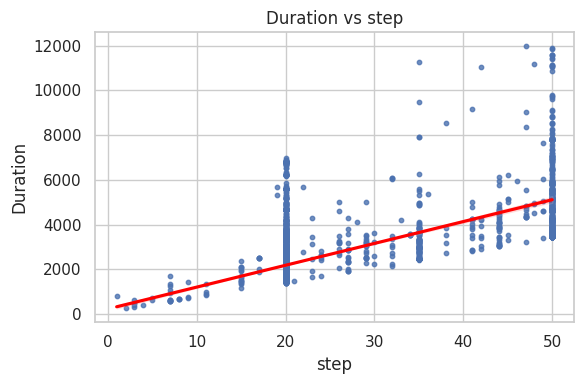

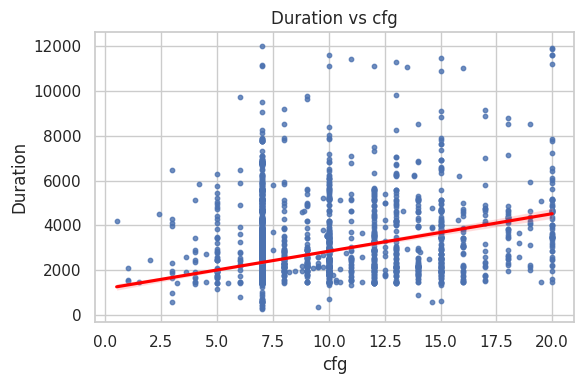

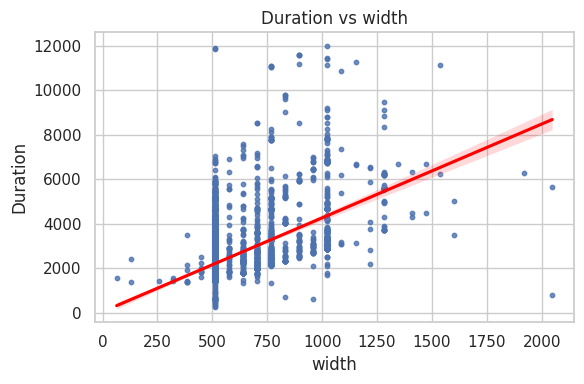

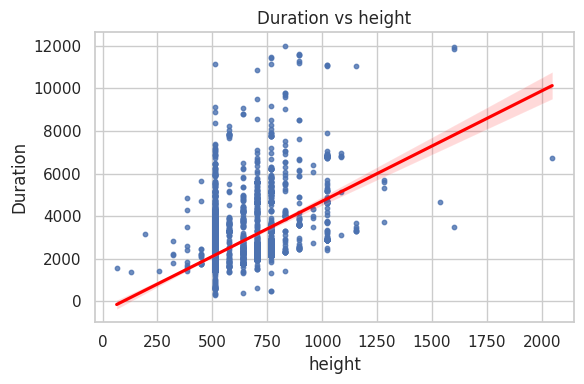

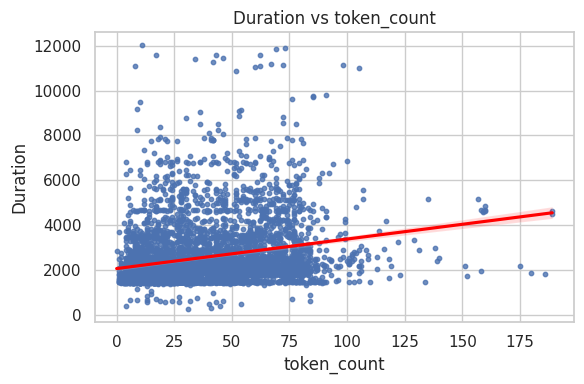

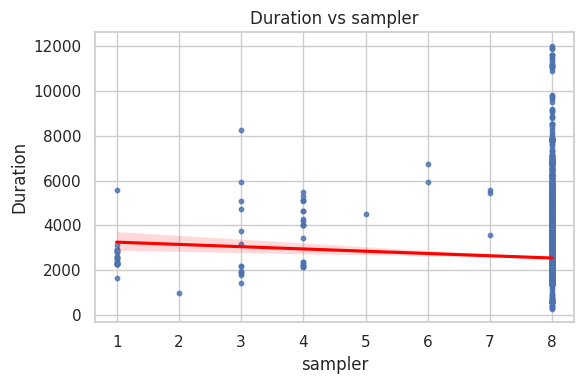

In [32]:
# 读取数据
df = pd.read_csv(dataset_path)

# 设置图形风格
sns.set(style="whitegrid")

# 数值型变量与 duration 的关系（散点图 + 拟合线）
numeric_cols = ["step", "cfg", "width", "height", "token_count", "sampler"]
for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=col, y="Duration", data=df, scatter_kws={"s": 10}, line_kws={"color": "red"})
    plt.title(f"Duration vs {col}")
    plt.tight_layout()
    plt.show()


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error

In [33]:
# 读取数据
df = pd.read_csv(dataset_path)

# one-hot 编码 sampler
ohe = OneHotEncoder(sparse_output=False)
sampler_encoded = ohe.fit_transform(df[['sampler']])
sampler_df = pd.DataFrame(sampler_encoded, columns=ohe.get_feature_names_out(['sampler']))

# 合并特征
X = pd.concat([df.drop(columns=['sampler', 'Id', 'Duration']), sampler_df], axis=1)
y = df['Duration']

# 训练集/测试集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征标准化（部分模型需要）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 模型列表
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(),
    "GBDT": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "MLP": MLPRegressor(max_iter=500),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
}

# 模型评估
results = {}
for name, model in models.items():
    if name in ["SVR", "MLP", "Gaussian Process", "KNN"]:  # 对这些模型使用缩放后的数据
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    results[name] = mse

# 输出结果
print("回归模型 MSE 对比：")
for name, mse in sorted(results.items(), key=lambda x: x[1]):
    print(f"{name}: {mse:.2f}")



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 211
[LightGBM] [Info] Number of data points in the train set: 3752, number of used features: 6
[LightGBM] [Info] Start training from score 2533.519190


/home/ypp/.cache/pypoetry/virtualenvs/modelling-NBOJOuuf-py3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


回归模型 MSE 对比：
GBDT: 103268.91
XGBoost: 116156.74
LightGBM: 120596.75
Random Forest: 124773.33
KNN: 196380.94
MLP: 197649.42
Linear Regression: 267361.96
Ridge Regression: 268269.82
SVR: 1835388.11


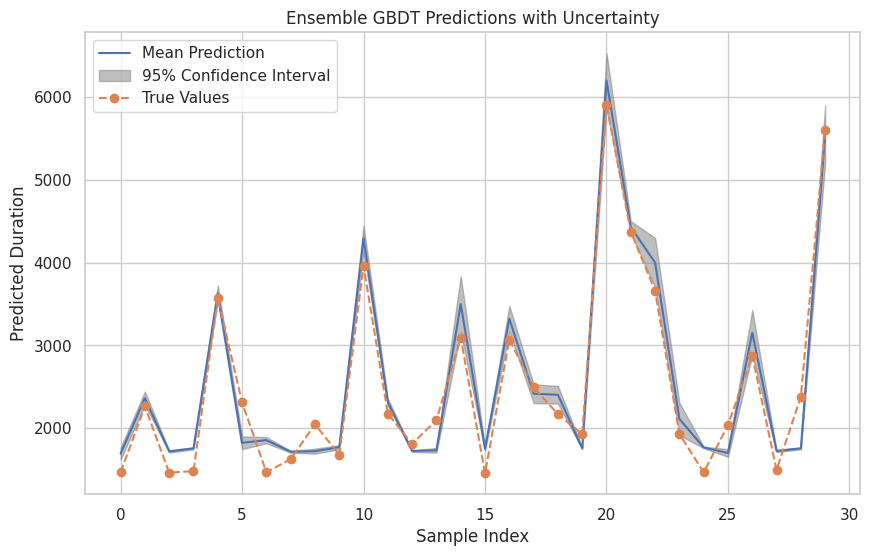

In [47]:
# 读取数据
df = pd.read_csv(dataset_path)

# one-hot 编码 sampler
ohe = OneHotEncoder(sparse_output=False)
sampler_encoded = ohe.fit_transform(df[['sampler']])
sampler_df = pd.DataFrame(sampler_encoded, columns=ohe.get_feature_names_out(['sampler']))

# 合并特征
X = pd.concat([df.drop(columns=['sampler', 'Id', 'Duration']), sampler_df], axis=1)
y = df['Duration']

# 训练集/测试集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 设置集成模型的数量
n_models = 10
models = []

# 训练多个 GBDT 模型
for i in range(n_models):
    model = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,         # <--- 每棵树只用80%的样本
        max_features='sqrt',   # <--- 每棵树只看sqrt(n_features)个特征
        random_state=i*42      # <--- 这时这个才有意义
    )
    model.fit(X_train, y_train)
    models.append(model)

# 对测试集进行预测，并收集所有模型的预测结果
predictions = np.array([model.predict(X_test) for model in models])

# 计算预测均值和标准差
mean_prediction = np.mean(predictions, axis=0)
std_prediction = np.std(predictions, axis=0)

# 可视化部分预测结果及其置信区间
visualize_indices = 30
plt.figure(figsize=(10, 6))
plt.plot(mean_prediction[:visualize_indices], label='Mean Prediction')
plt.fill_between(
    np.arange(visualize_indices),
    mean_prediction[:visualize_indices] - 1.96 * std_prediction[:visualize_indices],
    mean_prediction[:visualize_indices] + 1.96 * std_prediction[:visualize_indices],
    color='gray',
    alpha=0.5,
    label='95% Confidence Interval'
)
plt.plot(y_test[:visualize_indices].values, label='True Values', marker='o', linestyle='--')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Predicted Duration')
plt.title('Ensemble GBDT Predictions with Uncertainty')
plt.show()

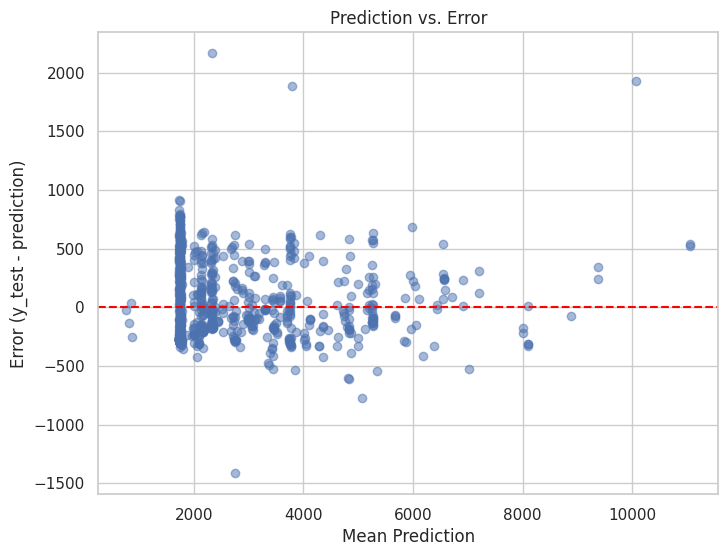

In [42]:
#计算模型和真实值之间的均方误差与预测大小的关系

# 计算误差（残差）
errors = y_test.values - mean_prediction

# 绘制散点图
plt.figure(figsize=(8, 6))
plt.scatter(mean_prediction, errors, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')  # 误差为0的参考线
plt.xlabel("Mean Prediction")
plt.ylabel("Error (y_test - prediction)")
plt.title("Prediction vs. Error")
plt.grid(True)
plt.show()

In [48]:
mse = mean_squared_error(y_test, mean_prediction)
print(f"Ensemble GBDT MSE: {mse:.2f}")

Ensemble GBDT MSE: 108739.71


In [49]:
from sklearn.model_selection import GridSearchCV

# 读取数据
df = pd.read_csv(dataset_path)

# one-hot 编码 sampler
ohe = OneHotEncoder(sparse_output=False)
sampler_encoded = ohe.fit_transform(df[['sampler']])
sampler_df = pd.DataFrame(sampler_encoded, columns=ohe.get_feature_names_out(['sampler']))

# 合并特征
X = pd.concat([df.drop(columns=['sampler', 'Id', 'Duration']), sampler_df], axis=1)
y = df['Duration']

# 训练集/测试集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
param_grid = {
    'learning_rate': [0.05, 0.075, 0.1, 0.125, 0.15],
    'max_depth': [2, 3, 4],
    'n_estimators': [150, 200, 250],
    'subsample': [0.7, 0.8, 0.9]
}

gbr = GradientBoostingRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.075, 0.1, 0.125, 0.15],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [150, 200, 250],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='neg_mean_squared_error', verbose=1)

In [54]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score (MSE):", -grid_search.best_score_)

# 用最优模型预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test MSE:", mean_squared_error(y_test, y_pred))

Best Parameters: {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best Score (MSE): 104826.9913691124
Test MSE: 101198.6441667893


In [55]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values("rank_test_score")
cv_results[["params", "mean_test_score", "std_test_score"]].head()

,params,mean_test_score,std_test_score
121,"{'learning_rate': 0.15, 'max_depth': 3, 'n_est...",-104826.991369,8312.619486
124,"{'learning_rate': 0.15, 'max_depth': 3, 'n_est...",-105012.676663,8207.825867
118,"{'learning_rate': 0.15, 'max_depth': 3, 'n_est...",-105343.763864,8512.850144
43,"{'learning_rate': 0.075, 'max_depth': 3, 'n_es...",-106499.795775,8420.463556
45,"{'learning_rate': 0.075, 'max_depth': 4, 'n_es...",-106677.532645,10892.559050


In [8]:
df = pd.read_csv(dataset_path)

# One-hot 编码
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
sampler_encoded = ohe.fit_transform(df[['sampler']])
sampler_df = pd.DataFrame(sampler_encoded, columns=ohe.get_feature_names_out(['sampler']))

# 合并特征
X = pd.concat([df.drop(columns=['sampler', 'Id', 'Duration']), sampler_df], axis=1)
y = df['Duration']

# 用调优后的参数训练模型
best_params = {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
model = GradientBoostingRegressor(**best_params, random_state=42)
model.fit(X, y)

# 对 train.csv 和 test.csv 进行预测
for file in ['../data/train.csv', '../data/test.csv']:
    data = pd.read_csv(file)

    # One-hot 编码 sampler（保持与训练一致）
    sampler_encoded = ohe.transform(data[['sampler']])
    sampler_df = pd.DataFrame(sampler_encoded, columns=ohe.get_feature_names_out(['sampler']))

    # 构建特征
    X_pred = pd.concat([
        data.drop(columns=['sampler', 'id', 'prompt']),
        sampler_df
    ], axis=1)

    # 预测
    y_pred = model.predict(X_pred)

    # 取整
    y_pred = np.round(y_pred).astype(int)

    # 构造输出
    output = data[['id', 'step', 'cfg', 'width', 'height', 'token_count', 'sampler']].rename(columns={'id': 'Id'}).copy()
    output['Duration'] = y_pred

    # 保存
    output_file = file.replace('.csv', '_regression.csv')
    output.to_csv(output_file, index=False)

print("✅ 已完成对 train.csv 和 test.csv 的预测，并生成对应的 train_regression.csv 和 test_regression.csv 文件。")

✅ 已完成对 train.csv 和 test.csv 的预测，并生成对应的 train_regression.csv 和 test_regression.csv 文件。


In [2]:
def enforce_min_duration(csv_path: str, output_path: str, min_duration: int = 1000):
    # 读取 CSV 文件
    df = pd.read_csv(csv_path)
    
    # 将 Duration 小于 min_duration 的值替换为 min_duration
    df['Duration'] = df['Duration'].apply(lambda x: max(x, min_duration))
    
    # 保存修改后的数据到新文件
    df.to_csv(output_path, index=False)

enforce_min_duration("../data/train_regression.csv", "../data/train_regression_clipped.csv")
enforce_min_duration("../data/test_regression.csv", "../data/test_regression_clipped.csv")
print("✅ 已完成对 train_regression.csv 和 test_regression.csv 的最小值限制处理，生成对应的 train_regression_clipped.csv 和 test_regression_clipped.csv 文件。")

✅ 已完成对 train_regression.csv 和 test_regression.csv 的最小值限制处理，生成对应的 train_regression_clipped.csv 和 test_regression_clipped.csv 文件。
